# Monkey Species Classification

In [5]:
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
from pathlib import Path
from tqdm import tqdm
import os

In [2]:
def create_df(path):
    X=[]
    y=[]
    for folder in os.listdir(path):
        label=int(folder[1])
        for image in tqdm(os.listdir(str(path)+'/'+folder)):
            img_file = cv2.imread(str(path)+'/'+folder+'/'+image)
            if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
        
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
    

In [3]:
cols = ['Label','Scientific Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("./archive/monkey_labels.txt", names=cols, skiprows=1)
train_dir = Path('./archive/training/training/')
val_dir = Path('./archive/validation/validation/')


X_train, y_train = create_df(train_dir)
X_val, y_val = create_df(val_dir)


100%|██████████| 28/28 [00:11<00:00,  2.45it/s]


In [18]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

In [11]:
print(labels)

   Label           Scientific Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 2

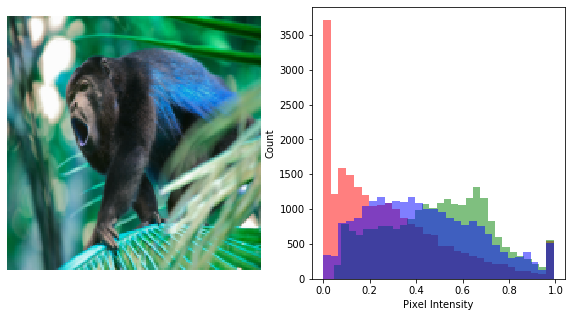

In [19]:
from random import randint
species = randint(0,130) #mantled_howler
#species = randint(131,269) #patas_monkey
#species = randint(270,406) #bald_uakari
#species = randint(407,558) #japanese_macaque
#species = randint(559,689) #pygmy_marmoset
#species = randint(690,830) #white_headed_capuchin
#species = randint(831,962) #silvery_marmoset
#species = randint(963,1104) #common_squirrel_monkey
#species = randint(1105,1237) #black_headed_night_monkey
#species = randint(1238,1369) #nilgiri_langur
plotHistogram(X_train[species])

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


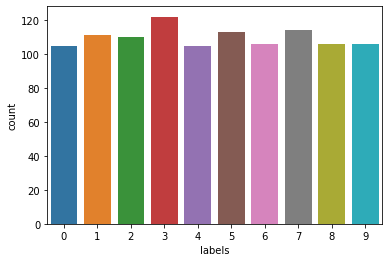

In [20]:
map_characters = {0: 'mantled_howler', 1: 'patas_monkey',2:'bald_uakari',3:'japanese_macaque',4:'pygmy_marmoset',5:'white_headed_capuchin',6:'silvery_marmoset',7:'common_squirrel_monkey',8:'black_headed_night_monkey',9:'nilgiri_langur'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [24]:
X_train.shape

(1098, 150, 150, 3)

In [28]:
nRows,nCols,nDims = X_train.shape[1:]
train_data = X_train.reshape(X_train.shape[0], nRows, nCols, nDims)
test_data = X_val.reshape(X_val.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

In [30]:
train_data /= 255
test_data /= 255

train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_val)

In [33]:
#pre-defined model definition from : https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model
model1 = createModel()
batch_size = 20
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
model1 = createModel()
batch_size = 256
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)       

In [36]:
history = model1.fit(X_train, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_data, test_labels_one_hot))

Epoch 1/50
5/5 [==============================] - 41s 8s/step - loss: 3.0380 - accuracy: 0.1166 - val_loss: 2.3030 - val_accuracy: 0.0956
Epoch 2/50
5/5 [==============================] - 37s 7s/step - loss: 2.2859 - accuracy: 0.1220 - val_loss: 2.3042 - val_accuracy: 0.0956
Epoch 3/50
5/5 [==============================] - 42s 8s/step - loss: 2.2972 - accuracy: 0.1712 - val_loss: 2.3083 - val_accuracy: 0.0993
Epoch 4/50
5/5 [==============================] - 47s 9s/step - loss: 2.2230 - accuracy: 0.2031 - val_loss: 2.3228 - val_accuracy: 0.0993
Epoch 5/50
5/5 [==============================] - 46s 9s/step - loss: 2.2397 - accuracy: 0.1821 - val_loss: 2.4713 - val_accuracy: 0.0993
Epoch 6/50
5/5 [==============================] - 45s 9s/step - loss: 2.2450 - accuracy: 0.2067 - val_loss: 2.4005 - val_accuracy: 0.0993
Epoch 7/50
5/5 [==============================] - 45s 9s/step - loss: 1.9921 - accuracy: 0.3015 - val_loss: 2.6713 - val_accuracy: 0.0993
Epoch 8/50
5/5 [==================